## Cross commodity portfolios

In this sample we illustrate how to define a portfolio that optimizes across different commodities. Here we take the example of heat and power, where a combined heat and power asset produces heat and power at the same time.

A (local) heat demand is fixed and power can be marketed in the power market. An additional power-to-heat asset enables us to convert power to heat

## Some prerequisites
### Basics

In [1]:
import numpy as np
import pandas as pd
import datetime as dt

import eaopack as eao

import matplotlib.pyplot as plt
%matplotlib inline

### Define the nodes for heat and power

(1) Nodes. In this example, we need to define a node for power and node for heat, since a node may only be used for one commodity. Accordingly we set different physical units for the nodes

In [2]:
unit_power = eao.assets.Unit(volume = 'MWh(el)', flow = 'MW(el)')
node_power = eao.assets.Node(name = 'power', unit = unit_power)
unit_heat  = eao.assets.Unit(volume = 'MWh(th)', flow = 'MW(th)')
node_heat     = eao.assets.Node(name = 'heat', unit = unit_heat)


(2) Assets

In this example we define several assets for illustration:
* a heat demand with a fixed profile. The heat demand must be met
* a heat storage
* a Combined heat and power (CHP) generator, that simultaneously generates heat and power
* a power-to-heat converter (e.g. heat pump)
* a power market where power may be bought or sold

In [3]:

## create battery
storage = eao.assets.Storage(name       = 'heat_storage', 
                            nodes       = node_heat, 
                            cap_out     = .5, 
                            cap_in      = .5, 
                            size        = 3., 
                            start_level = 0., 
                            end_level   = 0.,
                            eff_in      = 0.9, 
                            block_size  = 'd')     # optimization for each day independently 

power2heat   = eao.assets.MultiCommodityContract(name = 'power-2-heat', min_cap= 0, max_cap = 1, nodes = [node_power, node_heat], factors_commodities=[-1, 2])
power_gen    = eao.assets.MultiCommodityContract(name = 'CHP', extra_costs = 50, min_cap= 0, max_cap=1, nodes = [node_power, node_heat], factors_commodities=[0.8, 2.2])
market       = eao.assets.SimpleContract(name = 'power_market', price='price', min_cap= -10, max_cap=10, nodes = node_power)

Start = dt.date(2020,1,1)
End   = dt.date(2020,1,3)
dates = pd.date_range(Start, End, freq = 'h').values

heat_curve = {'start'  : dates, 
                'values' : - np.sin(np.linspace(0,3, len(dates)))}
heat_demand  = eao.assets.Contract(name = 'heat_demand',  extra_costs = -20, min_cap= heat_curve, max_cap=heat_curve, nodes = node_heat)
portf        = eao.portfolio.Portfolio([storage, power2heat, power_gen, market, heat_demand])
portf.set_timegrid(eao.assets.Timegrid(Start, End, freq = 'h'))

Note that the power-to-heat converter as well as the CHP plant live on both, heat and power, nodes. In our definition of the CHP, one dispatch unit translates to 0.8 MWh(el) and 2.2 MWh(th). If the CHP burns gas, we could easily add gas as the third commodity to link all markets

### The overall portfolio

The below network chart shows the setup of the portfolio. Note how our assets link both markets / commodities

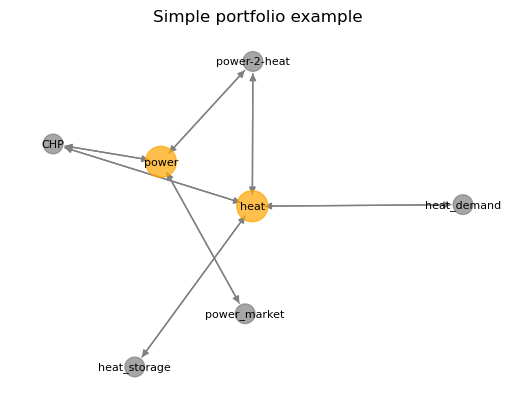

In [4]:
eao.network_graphs.create_graph(portf = portf, title = 'Simple portfolio example')

## Perform the optimization

Let's load some illustrative power price data and perform the optimization

In [5]:
prices = pd.read_csv('2020_price_sample.csv')
# cast to timegrid (in this case not necessary, but may be if input granularity does not correspond to timegrid in optimization)
prices = {'price': portf.timegrid.values_to_grid({'start': pd.to_datetime(prices['start'].values), 'values': prices['price'].values})}
op     = portf.setup_optim_problem(prices)
res    = op.optimize()
out    = eao.io.extract_output(portf, op, res, prices)

## Create charts and interpret the results

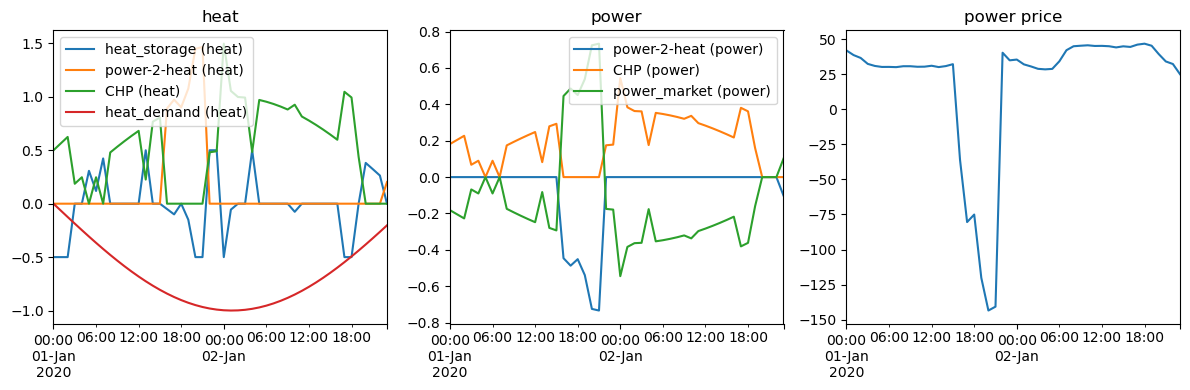

In [6]:
allcols = out['dispatch'].columns.values
heat = []
power = []
for mycol in allcols:
    if '(heat)' in mycol:
        heat.append(mycol)
    else:
        power.append(mycol)
fig, ax = plt.subplots(1,3, tight_layout = True, figsize=(12,4))
out['dispatch'][heat].plot(ax = ax[0], style = '-')
out['dispatch'][power].plot(ax = ax[1], style = '-')
out['prices']['input data: price'].plot(ax = ax[2], style = '-')
ax[0].set_title('heat')
ax[1].set_title('power')
ax[2].set_title('power price')
plt.show()


### Interpretation

Heat demand must be met in all times. Depending on prices, either CHP or power-2-heat will be utilized to meet heat demand. The heat storage is utilized to arbitrage between the best hours (mainly with regards to prices on the power market)